# SToP Search String

In [31]:
import csv

#Loading Bar
from ipywidgets import IntProgress
from IPython.display import display
import time

#String Search library
import re

In [6]:
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_Community1_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
        
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    
    Med_Array.append([ID, Product_Name, Start_Date])
    
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_Community1_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 1 - Date
# 3 - Presenting Complaint
# 4 - Primary Presenting Complaint
# 5 - Other Complaints
# 6 - Diagnosis
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Date = data[a][1]
    Presenting_complaint = data[a][3]
    Primary_presenting_complaint = data[a][4]
    Other_complaints = data[a][5]
    Diagnosis = data[a][6]
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis])

Med_Array contains some duplicates. Remove the duplicates for much less data combined data

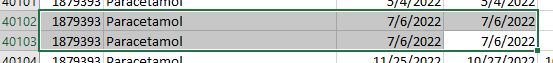

In [8]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [9]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)
UID = []
for a in range (0, len(new_Med_Array)):
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

In [10]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset
    Data_Array.append(temp_row)

IntProgress(value=1, max=702, min=1)

In [11]:
#Count missing linkage parts

count_missing_prog = 0
count_missing_med = 0
for a in range (0, len(Data_Array)):
    if len(Data_Array[a][1]) == 0:
        count_missing_prog = count_missing_prog + 1
    if len(Data_Array[a][0]) == 0:
        count_missing_med = count_missing_med + 1
        
print(count_missing_prog, count_missing_med)

2271 52169


In [132]:
Data_Array[1]

[[['18805', 'Aspirin', '5/6/2020'], ['18805', 'Ondansetron', '5/6/2020']],
 [['18805', '5/6/2020', 'Headache', '', '', '']]]

In [ ]:
# Search for the search terms

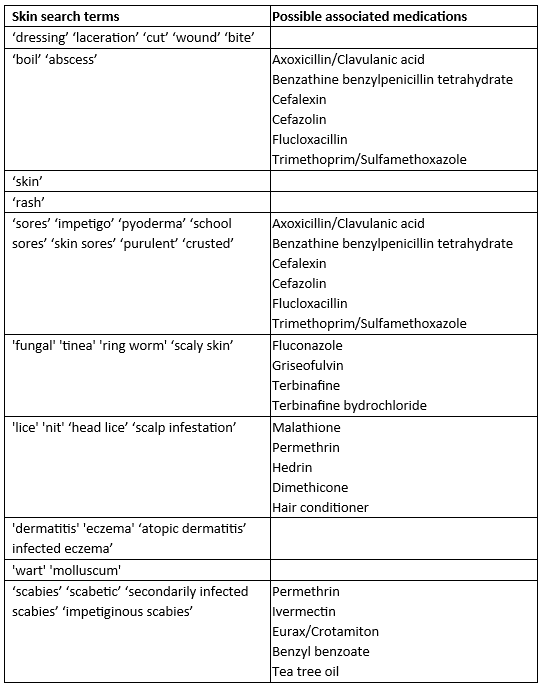

## Search 1 ["dressing", "laceration", "cut", "wound", "bite"]

In [152]:
import datetime
from datetime import datetime

In [260]:
search = ["dressing", "laceration", "cut", "wound", "bite"]
#Cut catches "acute", "subcutaneous", "electrocution"

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_id = Data_Array[a][1][b][0]

                #Convert to datetime.date() so it can be used to compare for consecutive windows
                temp_date = Data_Array[a][1][b][1]
                if temp_date != 'Day of Progress Note Date':
                    temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

                if re.search(searchstring, temp_string):
                    if searchstring == "cut":
                        if not re.search("acute", temp_string) and not re.search("subcutaneous", temp_string) and not re.search("electrocution", temp_string):
                            #print(a, temp_id, temp_date, b, temp_string)
                            temp.append([a, temp_id, temp_date, b, temp_string])
                    else:
                        #print(a, temp_date, b, temp_string)
                        temp.append([a, temp_id, temp_date, b, temp_string])
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
dressing
-----------------------
laceration
-----------------------
cut
-----------------------
wound
-----------------------
bite


In [261]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 238 dressing
1 196 laceration
2 28 cut
3 1160 wound
4 238 bite


## Search 2 ["boil", "abscess"]

In [297]:
search = ["boil", "abscess"]

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_id = Data_Array[a][1][b][0]

                #Convert to datetime.date() so it can be used to compare for consecutive windows
                temp_date = Data_Array[a][1][b][1]
                if temp_date != 'Day of Progress Note Date':
                    temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

                if re.search(searchstring, temp_string):
                    #print(a, temp_id, temp_date, b, temp_string)
                    temp.append([a, temp_id, temp_date, b, temp_string])
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
boil
-----------------------
abscess


In [298]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 348 boil
1 205 abscess


In [299]:
#Connect the progress note results with the associated medications.

med = [["axoxicillian", "clavulanic"], ["benzathine", "benzylpenicillin", "tetrahydrate"], ["cefalexin"], ["cefazolin"], ["flucloxacillin"], ["trimethoprim", "sulfamethoxazole"]]

#Create a Medication Results array with the same dimensions as the search terms
med_array = []
for a in range (0, len(results_array)):
    med_results = [0 for a in range (0, len(med))]
    for b in range (0, len(results_array[a])):
        #Find the Data row that the result comes from
        data_row = results_array[a][b][0]
        temp_datarow = Data_Array[data_row][0] #The medication reports
        
        #Check to see if there are any medication reports linked to this progress note
        if len(temp_datarow) > 0:
            for c in range (0, len(temp_datarow)):
                med_string = temp_datarow[c][1].lower()
                
                #Iterate through the search terms
                for d in range (0, len(med)):
                    
                    flag = False #Flag to determine if subsets of the medical terms is present
                    for e in range (0, len(med[d])):
                        medSearchString = med_4[d][e]
                        if re.search(medSearchString, med_string):
                            #print(medSearchString, "--------", med_string)
                            flag = True
                    if flag:
                        med_results[d] = med_results[d] + 1
    med_array.append(med_results)

In [300]:
med_array

[[1, 32, 3, 4, 8, 69], [17, 8, 2, 15, 13, 32]]

## Search 3 ["skin", "rash"]

In [302]:
search = ["skin", "rash"]

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                
                temp_id = Data_Array[a][1][b][0]

                #Convert to datetime.date() so it can be used to compare for consecutive windows
                temp_date = Data_Array[a][1][b][1]
                if temp_date != 'Day of Progress Note Date':
                    temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

                if re.search(searchstring, temp_string):
                    temp.append([a, temp_id, temp_date, b, temp_string])
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
skin
-----------------------
rash


In [303]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 525 skin
1 147 rash


In [307]:
for a in range (0, len(results_array)):
    #print(search[a])
    #print("----------------------------")
    for b in range (0, len(results_array[a])):
        #print(results_array[a][b][4])
        True

## Search 4 ["sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted"]

In [126]:
search_4 = ["sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted"]
med_4 = [["axoxicillian", "clavulanic"], ["benzathine", "benzylpenicillin", "tetrahydrate"], ["cefalexin"], ["cefazolin"], ["flucloxacillin"], ["trimethoprim", "sulfamethoxazole"]]

results_array_4 = []
med_array_4 = []
for searchstring in search_4: 
    print("-----------------------")
    print(searchstring) 
    temp = []
    med_results = [0 for a in range (0, len(med_4))]
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + Data_Array[a][1][b][3] + Data_Array[a][1][b][4] + Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_date = Data_Array[a][1][b][1]
                if re.search(searchstring, temp_string):
                    #print(a, temp_date, b, temp_string)
                    temp.append([a, temp_date, b, temp_string])
                    #Search through the medications
                    if len(Data_Array[a][0]) > 0:
                        for c in range (0, len(Data_Array[a][0])):
                            med_string = Data_Array[a][0][c][1].lower()
                            for d in range (0, len(med_4)):
                                flag = False
                                for e in range (0, len(med_4[d])):
                                    medSearchstring = med_4[d][e]
                                    if re.search(medSearchstring, med_string):
                                        #print(medSearchstring, "--------", med_string)
                                        flag = True
                                if flag:
                                    med_results[d] = med_results[d] + 1
                            #print(Data_Array[a][0][c])
    results_array_4.append(temp)
    med_array_4.append(med_results)

-----------------------
sores
-----------------------
impetigo
-----------------------
pyoderma
-----------------------
school sores
-----------------------
skin sores
-----------------------
purulent
-----------------------
crusted


In [127]:
med_array_4

[[0, 63, 0, 2, 0, 11],
 [0, 49, 2, 3, 1, 25],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 32, 0, 0, 0, 5],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0]]

In [128]:
for a in range (0, len(results_array_4)):
    print(a, len(results_array_4[a]), search_4[a])

0 138 sores
1 195 impetigo
2 1 pyoderma
3 1 school sores
4 66 skin sores
5 5 purulent
6 8 crusted


In [129]:
results_array_4[5]

[[17864,
  '10/17/2020',
  1,
  'sob - shortness of breathotitis media with effusion - purulent'],
 [53848,
  '4/15/2021',
  0,
  'otitis media with effusion - purulentotitis media with effusion - purulent'],
 [67719, '4/20/2020', 0, 'otitis media with effusion - purulent'],
 [67720, '4/21/2020', 0, 'otitis media with effusion - purulent'],
 [69700, '7/11/2022', 0, 'otitis media with effusion - purulent']]

In [133]:
Data_Array[67719]

[[],
 [['1205738',
   '4/20/2020',
   'Otitis media with effusion - purulent',
   '',
   '',
   ''],
  ['1205738', '4/20/2020', 'Cough', '', '', ''],
  ['1205738', '4/20/2020', 'Cough', '', '', 'Diabetes']]]

## Search 5 ["fungal", "tinea", "ring worm", "scaly skin"]

In [234]:
search_5 = ["fungal", "tinea", "ring worm", "scaly skin"]
search_5 = ["skin", "rash"]

results_array_5 = []
for searchstring in search_5: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] + " " + Data_Array[a][1][b][4] + " " + Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_date = Data_Array[a][1][b][1]
                if re.search(searchstring, temp_string):
                    #print(a, temp_date, b, temp_string)
                    temp.append([a, temp_date, b, temp_string])
    results_array_5.append(temp)

-----------------------
skin
-----------------------
rash


In [235]:
for a in range (0, len(results_array_5)):
    print(a, len(results_array_5[a]), search_5[a])

0 561 skin
1 160 rash


## Search 6 ["lice", "nit", "head lice", "scalp infestation"]

In [71]:
search_6 = ["lice", "nit", "head lice", "scalp infestation"]
#lice - police, license
#nit - community, cognitive

results_array_6 = []
for searchstring in search_6: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + Data_Array[a][1][b][3] + Data_Array[a][1][b][4] + Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_date = Data_Array[a][1][b][1]
                if re.search(searchstring, temp_string):
                    #print(a, temp_date, b, temp_string)
                    temp.append([a, temp_date, b, temp_string])
    results_array_6.append(temp)

-----------------------
lice
-----------------------
nit
-----------------------
head lice
-----------------------
scalp infestation


In [70]:
for a in range (0, len(results_array_6)):
    print(a, len(results_array_6[a]), search_6[a])

0 113 lice
1 4 nits
2 45 head lice
3 0 scalp infestation


## Search 7 ["dematitis", "eczema", "atopic dermatitis", "infected eczema"]

In [74]:
search_7 = ["dermatitis", "eczema", "atopic dermatitis", "infected eczema"]

results_array_7 = []
for searchstring in search_7: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + Data_Array[a][1][b][3] + Data_Array[a][1][b][4] + Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_date = Data_Array[a][1][b][1]
                if re.search(searchstring, temp_string):
                    #print(a, temp_date, b, temp_string)
                    temp.append([a, temp_date, b, temp_string])
    results_array_7.append(temp)

-----------------------
dermatitis
-----------------------
eczema
-----------------------
atopic dermatitis
-----------------------
infected eczema


In [75]:
for a in range (0, len(results_array_7)):
    print(a, len(results_array_7[a]), search_7[a])

0 21 dermatitis
1 7 eczema
2 0 atopic dermatitis
3 1 infected eczema


## Search 8 ["wart", "molluscum"]

In [76]:
search_8 = ["wart", "mulluscum"]

results_array_8 = []
for searchstring in search_8: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + Data_Array[a][1][b][3] + Data_Array[a][1][b][4] + Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_date = Data_Array[a][1][b][1]
                if re.search(searchstring, temp_string):
                    #print(a, temp_date, b, temp_string)
                    temp.append([a, temp_date, b, temp_string])
    results_array_8.append(temp)

-----------------------
wart
-----------------------
mulluscum


In [77]:
for a in range (0, len(results_array_8)):
    print(a, len(results_array_8[a]), search_8[a])

0 21 wart
1 0 mulluscum


## Search 9 ["scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"]

In [80]:
search_9 = ["scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"]

results_array_9 = []
for searchstring in search_9: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            for b in range (0, len(Data_Array[a][1])):
                temp_string = Data_Array[a][1][b][2] + Data_Array[a][1][b][3] + Data_Array[a][1][b][4] + Data_Array[a][1][b][5]
                temp_string = temp_string.lower()
                temp_date = Data_Array[a][1][b][1]
                if re.search(searchstring, temp_string):
                    #print(a, temp_date, b, temp_string)
                    temp.append([a, temp_date, b, temp_string])
    results_array_9.append(temp)

-----------------------
scabies
-----------------------
scabetic
-----------------------
secondarily infected scabies
-----------------------
impetiginous scabies


In [81]:
for a in range (0, len(results_array_9)):
    print(a, len(results_array_9[a]), search_9[a])

0 168 scabies
1 0 scabetic
2 0 secondarily infected scabies
3 0 impetiginous scabies
